In [11]:

#Import all required libraries
import spacy
import random
import time
import numpy as np
from spacy.util import minibatch, compounding
import sys
from spacy import displacy
from itertools import chain
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator

In [12]:
def load_data_spacy(file_path):
 
    file = open(file_path, 'r')
    training_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start =0
    end = 0 # initialize counter to keep track of start and end characters
    for line in file:
        line = line.strip("\n").split("\t")
        # lines with len > 1 are words
        if len(line) > 1:
            label = line[1]
            if(label != 'O'):
                label = line[1]+"_Disease"     # the .txt is formatted: label \t word, label[0:2] = label_type
            #label_type = line[0][0] # beginning of annotations - "B", intermediate - "I"
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)  # length of the word + trailing space
           
            if label == 'I_Disease' :  # if at the end of an annotation
                entities.append(( start,end-1, label))  # append the annotation
                              
            if label == 'B_Disease':                         # if beginning new annotation
                entities.append(( start,end-1, label))# start annotation at beginning of word
                
           
           
            if label != 'O' and label not in unique_labels:
                unique_labels.append(label)
 
        # lines with len == 1 are breaks between sentences
        if len(line) == 1:
            if(len(entities) > 0):
                sentence = " ".join(sentence)
                training_data.append([sentence, {'entities' : entities}])
            # reset the counters and temporary lists
            end = 0 
            start = 0
            entities, sentence = [], []
            
    file.close()
    return training_data, unique_labels

In [ ]:
TRAIN_DATA, LABELS = load_data_spacy("/train.tsv")
print(TRAIN_DATA)
print(len(TRAIN_DATA))
TEST_DATA, _ = load_data_spacy("/test.tsv")
print(len(TEST_DATA))
VALID_DATA, _ = load_data_spacy("/train_dev.tsv")
print(len(VALID_DATA))

In [14]:
def calc_precision(pred, true):        
    precision = len([x for x in pred if x in true]) / (len(pred) + 1e-20) # true positives / total pred
    return precision

def calc_recall(pred, true):
    recall = len([x for x in true if x in pred]) / (len(true) + 1e-20)    # true positives / total test
    return recall

def calc_f1(precision, recall):
    f1 = 2 * ((precision * recall) / (precision + recall + 1e-20))
    return f1

In [15]:
# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents] # i.label_ = annotation label, pred.ents = list of annotations
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    #print("Precision: {} \nRecall: {} \nF1-score: {}".format(np.around(np.mean(precisions), 3),np.around(np.mean(recalls), 3),
    #                                                         np.around(np.mean(f1s), 3)))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f":np.mean(f1s)}

In [16]:
# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(ner, data ):
    preds = [ner(x[0]) for x in data]

    precisions, recalls, f1s = [], [], []

    # iterate over predictions and test data and calculate precision, recall, and F1-score
    for pred, true in zip(preds, data):
        true = [x[2] for x in list(chain.from_iterable(true[1].values()))] # x[2] = annotation, true[1] = (start, end, annot)
        pred = [i.label_ for i in pred.ents] # i.label_ = annotation label, pred.ents = list of annotations
        precision = calc_precision(true, pred)
        precisions.append(precision)
        recall = calc_recall(true, pred)
        recalls.append(recall)
        f1s.append(calc_f1(precision, recall))

    #print("Precision: {} \nRecall: {} \nF1-score: {}".format(np.around(np.mean(precisions), 3),np.around(np.mean(recalls), 3),
    #                                                         np.around(np.mean(f1s), 3)))
    return {"textcat_p": np.mean(precisions), "textcat_r": np.mean(recalls), "textcat_f":np.mean(f1s)}

In [21]:

def train_spacy(train_data, labels, iterations, dropout = 0.5, display_freq = 1):
    ''' Train a spacy NER model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {entities: [(start, end, label)]})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    valid_f1scores=[]
    test_f1scores=[]
    nlp = spacy.load("en_core_web_lg")
    #nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe("ner")
   
    # Add entity labels to the NER pipeline
    for i in labels:
        ner.add_label(i)

    # Disable other pipelines in SpaCy to only train NER
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        #nlp.vocab.vectors.name = 'spacy_model' # without this, spaCy throws an "unnamed" error
        optimizer = nlp.begin_training()
        for itr in range(iterations):
            random.shuffle(train_data) # shuffle the training data before each iteration
            losses = {}
            batches = minibatch(train_data, size = compounding(16.0, 64.0, 1.5))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(          
                    texts,
                    annotations,
                    drop = dropout,  
                    sgd = optimizer,
                    losses = losses)
            #if itr % display_freq == 0:
            #    print("Iteration {} Loss: {}".format(itr + 1, losses))
            scores = evaluate(nlp,VALID_DATA)
            valid_f1scores.append(scores["textcat_f"])
            print('=======================================')
            print('Interation = '+str(itr))
            print('Losses = '+str(losses))
            print('===============VALID DATA========================')
            
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            scores = evaluate(nlp,TEST_DATA)
            test_f1scores.append(scores["textcat_f"])
            print('===============TEST DATA========================')
            print('F1-score = '+str(scores["textcat_f"]))
            print('Precision = '+str(scores["textcat_p"]))
            print('Recall = '+str(scores["textcat_r"]))
            print('=======================================')
            
    return nlp,valid_f1scores,test_f1scores

In [22]:

# Train (and save) the NER model
ner,valid_f1scores,test_f1scores = train_spacy(TRAIN_DATA, LABELS,20)
ner.to_disk("\spacy_example")

Interation = 0
Losses = {'ner': 54236.53016662598}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 1
Losses = {'ner': 47228.66827964783}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 2
Losses = {'ner': 46570.49143218994}
===============VALID DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
===============TEST DATA========================
F1-score = 0.0
Precision = 0.0
Recall = 0.0
Interation = 3
Losses = {'ner': 46723.508350372314}
===============VALID DATA========================
F1-score = 0.00018570102135561745
Precision = 0.00018570102135561745
Recall = 0.00018570102135561745
===============TEST DATA========================
F1-score = 0.0003518648838845883
P

Text(0.5, 1.0, 'F1 score vs Iterations for validation and test data')

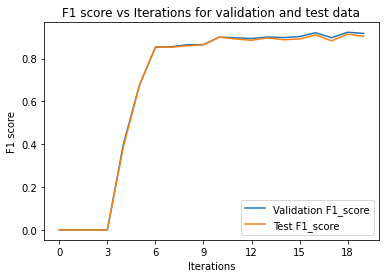

In [23]:
x=range(0,20)
 
ax = plt.figure().gca()
#...
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(valid_f1scores,label="Validation F1_score")
ax.plot(test_f1scores,label="Test F1_score")
ax.set_xlabel('Iterations')
ax.set_ylabel('F1 score')
ax.legend()
ax.set_title('F1 score vs Iterations for validation and test data')

In [24]:
def load_model(model_path):
    ''' Loads a pre-trained model for prediction on new test sentences
   
    model_path : directory of model saved by spacy.to_disk
    '''
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

In [ ]:
ner = load_model("\spacy_example")



test_sentences = [x[0] for x in TEST_DATA[0:4000]] # extract the sentences from [sentence, entity]
for x in test_sentences:
    doc = ner(x)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc,jupyter=True, style = "ent")

In [26]:
ner = load_model("\spacy_example")
doc = ner("Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal.The aims of this study were to confirm our previous findings in a separate cohort of patients and to determine the time course of the cardiovascular consequences of stopping selegiline in the expectation that this might shed light on the mechanisms by which the drug causes orthostatic hypotension")
displacy.render(doc,jupyter=True, style = "ent")

In [28]:
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 827.9MB 1.1MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180945 sha256=5af1589f62d4dc3d1bd89603d7a9093ac180fb4d2640318324382acc95569e79
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5arqb7g/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [20]:
import spacy
nlp = spacy.load('en_core_web_lg')